In [1]:
#pip install cleantext #I think I only need to do this once, is that correct?

In [197]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from numpy.linalg import norm
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import cleantext
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

If our first author-independent goal is to build a giant vector of possible words from training set, then maybe the correct approach is to sequentially read through all of the different word files and make a set or dictionary of all terms we encounter.  If we build a dictionary, then the word itself can be the key, and each time the word is encuontered the value is updated by 1.

The advantage of doing a dictionary like that would be that we could do a dimensionality reduction on those elements that have entries across many different authors.  We might not want to get rid of text entries that are common for one single author.  So, perhaps the value of each dictionary key would be a 50-tuple with the number of times each word appeared for each author.

In [143]:
def cmer(name, c=3):
    r""" Given a name and parameter c, return the vector of c-mers associated with the name
    """
    #print(len(name),c)
    if c > len(name):
        print("c must be less than equal to the character length of ", name)
        return -1
    if c <= 0:
        print("The integer value of c must be greater than 0")
        return -2
    #I think this is already done in other function name = name.lower()
    v = []
    for i in range(len(name)-c+1):
        v.append(name[i:i+c])    
    return v

In [162]:
#These functions are from the class activity nn-classication
def build_matrix(docs):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
    nrows = len(docs) #a "doc" here is a list of words.  
    idx = {}
    tid = 0
    nnz = 0
    for d in docs:
        print(d) #for test
        nnz += len(set(d))
        for w in d:
            if w not in idx:
                idx[w] = tid
                tid += 1
    ncols = len(idx)
        
    # set up memory
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0  # document ID / row counter
    n = 0  # non-zero counter
    # transfer values
    for d in docs:
        cnt = Counter(d)
        keys = list(k for k,_ in cnt.most_common())
        l = len(keys)
        for j,k in enumerate(keys):
            ind[j+n] = idx[k]
            val[j+n] = cnt[k]
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
            
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat

def csr_info(mat, name="", non_empty=False):
    r""" Print out info about this CSR matrix. If non_empty, 
    report the number of non-empty rows and cols as well
    """
    if non_empty:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )

def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat
        
def namesToMatrix(names, c):
    docs = [cmer(n, c) for n in names]
    print(docs)
    return build_matrix(docs)

In [163]:
import glob
txtfiles = []
author_names=[]
#for file in glob.glob("authorship_data/C50/C50train/AaronPressman/*.txt"):
for file in glob.glob("authorship_data/C50/C50train/*/*.txt"):
    txtfiles.append(file)
#print(txtfiles)
for dirName in glob.glob("authorship_data/C50/C50train/*/"):
    author_names.append(dirName[29:-1])
#author_words = dict(author_names)
print(author_names)

['AaronPressman', 'AlanCrosby', 'AlexanderSmith', 'BenjaminKangLim', 'BernardHickey', 'BradDorfman', 'DarrenSchuettler', 'DavidLawder', 'EdnaFernandes', 'EricAuchard', 'FumikoFujisaki', 'GrahamEarnshaw', 'HeatherScoffield', 'JaneMacartney', 'JanLopatka', 'JimGilchrist', 'JoeOrtiz', 'JohnMastrini', 'JonathanBirt', 'JoWinterbottom', 'KarlPenhaul', 'KeithWeir', 'KevinDrawbaugh', 'KevinMorrison', 'KirstinRidley', 'KouroshKarimkhany', 'LydiaZajc', "LynneO'Donnell", 'LynnleyBrowning', 'MarcelMichelson', 'MarkBendeich', 'MartinWolk', 'MatthewBunce', 'MichaelConnor', 'MureDickie', 'NickLouth', 'PatriciaCommins', 'PeterHumphrey', 'PierreTran', 'RobinSidel', 'RogerFillion', 'SamuelPerry', 'SarahDavison', 'ScottHillis', 'SimonCowell', 'TanEeLyn', 'TheresePoletti', 'TimFarrand', 'ToddNissen', 'WilliamKazer']


In [164]:
#this is a test of the sparse matrix generation.  I would like to run it on cleaned up lists of words in each document 

In [165]:
# Create an empty list, for the words from all articles from each author
list_of_authors_words = []
# Iterate over a sequence of numbers from 0 to 4
for i in range(50):
    # In each iteration, add an empty list to the main list
    list_of_authors_words.append([''])

In [166]:
#This is the set of all words in all files after removal of stop words, etc.
allWords=set([''])
temp_authors_words = set([''])
# read in the dataset
i=0
j=0
for tf in txtfiles:
    j = j+1
    current_author_base = tf[29:-1]
    current_author_name_slash_index=current_author_base.index("\\")
    current_author = current_author_base[0:current_author_name_slash_index]
    if i == 0:
        last_author_processed = "None"
    #with open("authorship_data/C50/C50train/AaronPressman/2537newsMl.txt", "r", encoding="utf8") as fh: 
    with open(tf, "r", encoding="utf8") as fh: 
        #print(tf)
        lines = fh.readlines()
        for l in lines:
            #print("cab=",current_author_base)
            if i>0 and i % 50 == 0:
                list_of_authors_words[int(i/50)] = list(temp_authors_words)
                #print(tempAuthorWordSet)
                #temp_authors_words = set([''])
            #print('j = ',j)
            #tempWordSet=set(l.split(" "))
            tempWordSet=set(cleantext.clean_words(l, all=True))  #test
            tempAuthorWordSet = set(cleantext.clean_words(l, all=True))  #test
            temp_authors_words=temp_authors_words.union(tempAuthorWordSet)
            allWords = allWords.union(tempWordSet)
            #print("temp_authors_words = ",temp_authors_words)

    i=i+1
    #print('i = ',i)
    if i % 50 == 1:
        print("i = ", i, "j =", j, "current author = ",current_author, " last author processed =",last_author_processed)
    last_author_processed=current_author # for each file
    if i % 50 == 1:
        list_of_authors_words[int(i/50)] = sorted(list(temp_authors_words)) #added sorted, don't know if it helps
        temp_authors_words = set([''])
print(list_of_authors_words[0])

        #print("last_author_processed = ", last_author_processed)
for i in range(50):
    list_of_authors_words[i] = (list_of_authors_words[i])[1:]
print(list_of_authors_words)
sortedWords = list(allWords)
sortedWords.sort()
sortedWords=sortedWords[1:]
print(len(sortedWords))

i =  1 j = 1 current author =  AaronPressman  last author processed = None
i =  51 j = 51 current author =  AlanCrosby  last author processed = AaronPressman
i =  101 j = 101 current author =  AlexanderSmith  last author processed = AlanCrosby
i =  151 j = 151 current author =  BenjaminKangLim  last author processed = AlexanderSmith
i =  201 j = 201 current author =  BernardHickey  last author processed = BenjaminKangLim
i =  251 j = 251 current author =  BradDorfman  last author processed = BernardHickey
i =  301 j = 301 current author =  DarrenSchuettler  last author processed = BradDorfman
i =  351 j = 351 current author =  DavidLawder  last author processed = DarrenSchuettler
i =  401 j = 401 current author =  EdnaFernandes  last author processed = DavidLawder
i =  451 j = 451 current author =  EricAuchard  last author processed = EdnaFernandes
i =  501 j = 501 current author =  FumikoFujisaki  last author processed = EricAuchard
i =  551 j = 551 current author =  GrahamEarnshaw  l

In [167]:
def plotWf(docs, plot=True, logscale=True):
    r"""Get collection-wide word frequencies and optionally plot them."""
    words = defaultdict(int)
    for d in docs:
        for w in d:
            words[w] += 1
    if plot is True:
        plt.plot(sorted(words.values(), reverse=True))
        plt.xlabel('word')
        plt.ylabel('frequency')
        if logscale is True:
            plt.yscale('log')
            plt.ylabel('log(frequency)')
        plt.title('Corpus-wide word frequency distribution')
        plt.show()
    return words

def plotDf(docs, plot=True, logscale=False):
    r"""Get collection-wide document-word frequencies and optionally plot them."""
    # document word frequency
    df = defaultdict(int)
    for d in docs:
        for w in set(d):
            df[w] += 1
    if plot is True:
        plt.plot(sorted(df.values(), reverse=True))
        plt.xlabel('word')
        plt.ylabel('frequency')
        if logscale is True:
            plt.yscale('log')
            plt.ylabel('log(frequency)')
        plt.title('Corpus-wide document-word frequency distribution')
        plt.show()
    return df

In [180]:
def filterLen(docs, minlen):
    r""" filter out terms that are too short. 
    docs is a list of lists, each inner list is a document represented as a list of words
    minlen is the minimum length of the word to keep
    """
    return [ [t for t in d if len(t) >= minlen ] for d in docs ]

In [188]:
c=5
list_of_authors_words2 = filterLen(list_of_authors_words,c)

<class 'list'>


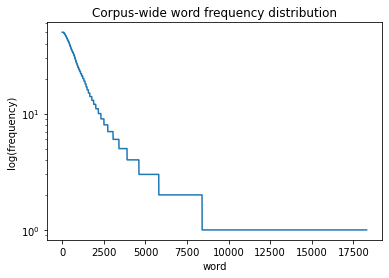

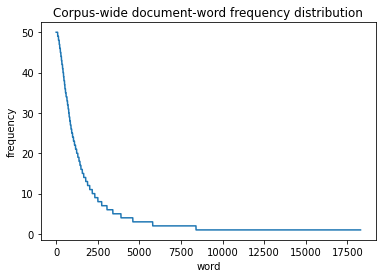

In [189]:
print(type(list_of_authors_words2))
_ = plotWf(list_of_authors_words2)
_ = plotDf(list_of_authors_words2)

In [190]:
#empty entry should have been remove in filterLen
#for i in range(50): #is there a better way to remove the empty entry from initializatin?
#    list_of_authors_words[0] = (list_of_authors_words[i])[1:]
#print(list_of_authors_words2[20])
#I should check I don't have any off by one effects, and also, should I sorted these lists?

In [191]:
#print(len(list_of_authors_words))


mat_out=build_matrix(list_of_authors_words2)
#list_of_authors_words_test = list_of_authors_words[0]
#mat_out2=namesToMatrix(list_of_authors_words_test,c-1)


['abandon', 'abroad', 'absolut', 'accept', 'accid', 'accompani', 'accord', 'account', 'achiev', 'acquir', 'acquisit', 'across', 'action', 'activ', 'actual', 'actuat', 'addit', 'address', 'adjac', 'adjourn', 'adjust', 'administr', 'advanc', 'advantag', 'advers', 'advertis', 'advic', 'advoc', 'affair', 'affect', 'aflcio', 'afternoon', 'aftersal', 'aftershock', 'aftertax', 'agenc', 'aggress', 'agreement', 'ahead', 'alarm', 'align', 'alleg', 'allegedli', 'allianc', 'allnew', 'allow', 'almost', 'alreadi', 'altern', 'although', 'alvin', 'alway', 'ambiti', 'amend', 'america', 'american', 'amherst', 'among', 'amount', 'analysi', 'analyst', 'angel', 'anniversari', 'announc', 'annual', 'anoth', 'answer', 'anticip', 'antilock', 'anybodi', 'anywher', 'apach', 'appar', 'appeal', 'appear', 'applaud', 'appoint', 'apprehend', 'approv', 'approxim', 'april', 'arborn', 'archer', 'arent', 'around', 'arrang', 'array', 'arriv', 'asiapacif', 'assaulttyp', 'assembl', 'asset', 'assign', 'assist', 'associ', 'as

In [192]:
#print(mat.shape)
mat_out_norm = csr_l2normalize(mat_out, copy=True)
print(mat_out_norm.shape)
csr_info(mat_out, name="test", non_empty=True)

(50, 18293)
test [nrows 50 (50 non-empty), ncols 18293 (18293 non-empty), nnz 89875]


In [194]:
#maybe do pca first
#from sklearn import decomposition
#from sklearn import datasets
#pca = decomposition.PCA(n_components=3)
#pca.fit(mat_out)

In [203]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=49)
yy=kmeans.fit(mat_out)


In [204]:
#I need to import the test set and run on the test set
print(yy)

KMeans(n_clusters=49)


In [200]:
print(mat_out.shape)

(50, 18293)
